# Plot results from `nb_papermill.py`

Import necessary libraries

In [3]:
import os
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jaxopt
import pyproximal
import pylops
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
import matplotlib.patches as patches
import matplotlib.colors as colors

import numpy as np
import scipy
import seaborn as sns
import multidms
import pickle as pkl
import glob
from collections import defaultdict

Organize the results into a `DataFrame`

In [4]:
results_dir = "results/unweighted_obj_sweep"
output_dir = f"{results_dir}/aggregated_results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [5]:
def parse_results_dir_name(dir_path):
    # parse the directory name
    dir_name = dir_path.split("/")[-1]
    hyperparams = {}
    for param in dir_name.split("--"):
        key, value = param.split("=")
        hyperparams[key] = value
    return hyperparams

In [6]:

results = defaultdict(list)
string_features = []
for dir in glob.glob(results_dir+"/*"):
    if dir == output_dir: continue
    hyperparams = parse_results_dir_name(dir)
    # if hyperparams["smooth_obj_fn"] == "cond_norm_equal_penalty": continue
    for key, value in hyperparams.items():
        string_features.append(key)
        results[key].append(value)
    for pck_fi in glob.glob(dir + "/*.pkl"):
        with open(pck_fi, "rb") as f:
            results[pck_fi.split("/")[-1].split(".")[0]].append(pkl.load(f))
    results["converged"].append(results["state"][-1].iter_num < 100000)
results_df = pd.DataFrame(results)
results_df.head()

,data_replicate,lasso_coeff,post_latent_fn,smooth_obj_fn,total_iterations,sparsity,params,D,data,state,error,obj,converged
0,1,0.00064,linear,cond_norm_penalty,100000,"[[0.9988695242581253, 1.0, 0.9989637305699481]...","{'Δ': [[-0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0...","[[1.0, -1.0, 0.0], [0.0, 0.0, 0.0], [0.0, -1.0...",Data(rep-1),"(13951, 32.0, 9.208939431362741e-05, None, {'Δ...","[0.12138014200421336, 0.10061762776220257, 0.0...","[0.8995202647454207, 0.8331803272283497, 0.789...",True
1,1,0.00064,linear,cond_norm_equal_penalty,100000,"[[0.9988695242581253, 1.0, 0.9989637305699481]...","{'Δ': [[-0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0...","[[1.0, -1.0, 0.0], [0.0, 0.0, 0.0], [0.0, -1.0...",Data(rep-1),"(13804, 32.0, 9.936136147473838e-05, None, {'Δ...","[0.12138014200421336, 0.10061762776228926, 0.0...","[0.8995202647453078, 0.8331803272272358, 0.789...",True
2,2,4e-05,linear,cond_norm_penalty,100000,"[[0.8261518373437792, 1.0, 0.8725983958216751]...","{'Δ': [[0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0...","[[1.0, -1.0, 0.0], [0.0, 0.0, 0.0], [0.0, -1.0...",Data(rep-2),"(12233, 32.0, 9.962653426020102e-05, None, {'Δ...","[0.1333798378455181, 0.11245823512897972, 0.08...","[1.0630034726476882, 0.9789544296228233, 0.917...",True
3,2,4e-05,linear,cond_norm_equal_penalty,100000,"[[0.8261518373437792, 1.0, 0.8725983958216751]...","{'Δ': [[0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0...","[[1.0, -1.0, 0.0], [0.0, 0.0, 0.0], [0.0, -1.0...",Data(rep-2),"(12268, 32.0, 9.962802770167414e-05, None, {'Δ...","[0.1333798378455181, 0.11245823512879355, 0.08...","[1.0630034726476192, 0.9789544296225023, 0.917...",True
4,2,4e-05,linear,all_sample_norm,100000,"[[0.7910837530311509, 1.0, 0.8267114344338743]...","{'Δ': [[-0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, ...","[[1.0, -1.0, 0.0], [0.0, 0.0, 0.0], [0.0, -1.0...",Data(rep-2),"(19702, 16.0, 9.983417756287245e-05, None, {'Δ...","[0.1350950493239494, 0.1130840954488026, 0.078...","[1.1045686135471886, 1.0205095561785418, 0.961...",True


In [7]:
results_df["converged"].value_counts()

converged
True     35
False     1
Name: count, dtype: int64

Let's make sure all fits here converged

In [8]:
results_df["lasso_coeff"] = results_df["lasso_coeff"].astype(float)
id_vars = list(set(string_features))
results_df[id_vars + ["converged"]].sort_values(id_vars)

,post_latent_fn,lasso_coeff,total_iterations,data_replicate,smooth_obj_fn,converged
14,linear,0.00000,100000,1,all_sample_norm,True
31,linear,0.00000,100000,1,cond_norm_equal_penalty,True
29,linear,0.00000,100000,1,cond_norm_penalty,True
32,linear,0.00000,100000,2,all_sample_norm,True
24,linear,0.00000,100000,2,cond_norm_equal_penalty,True
7,linear,0.00000,100000,2,cond_norm_penalty,True
21,linear,0.00004,100000,1,all_sample_norm,True
16,linear,0.00004,100000,1,cond_norm_equal_penalty,True
19,linear,0.00004,100000,1,cond_norm_penalty,True
4,linear,0.00004,100000,2,all_sample_norm,True


In [9]:
%matplotlib inline

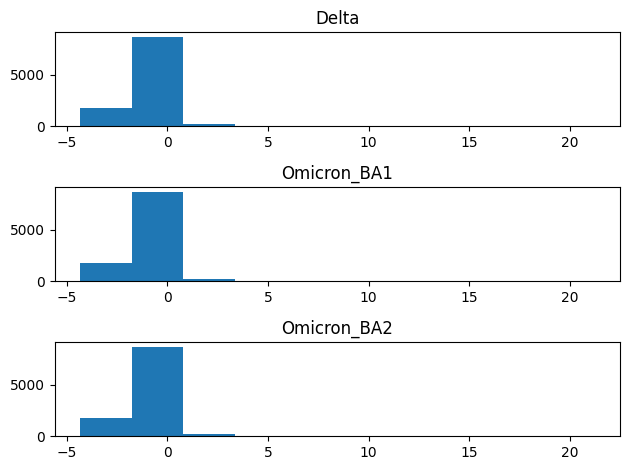

In [10]:
model_params = results_df.loc[0, "params"]["β"]
fig, ax = plt.subplots(3,1)
for i, (key, value) in enumerate(model_params.items()):
    ax[i].hist(value)
    ax[i].set_title(key)
plt.tight_layout()
plt.show()

In [11]:
non_lasso_groupers = set(string_features) - set(["lasso_coeff"])
print(non_lasso_groupers)

{'smooth_obj_fn', 'total_iterations', 'data_replicate', 'post_latent_fn'}


In [12]:
non_lasso_groupers = non_lasso_groupers - set(["data_replicate", "theta_scale_upper_bound", "total_iterations", "l2reg_theta_scale", "l2reg_beta", "equivariant"])
print(non_lasso_groupers)

{'post_latent_fn', 'smooth_obj_fn'}


In [13]:
len(results_df)

36

In [14]:
# Change type of lasso_coeff to categorical dtype sorted by value
results_df["lasso_coeff"] = results_df["lasso_coeff"].astype("float")
results_df["lasso_coeff_cat"] = pd.Categorical(results_df["lasso_coeff"], categories=sorted(results_df["lasso_coeff"].unique()))

post_latent_fn=linear
smooth_obj_fn=all_sample_norm


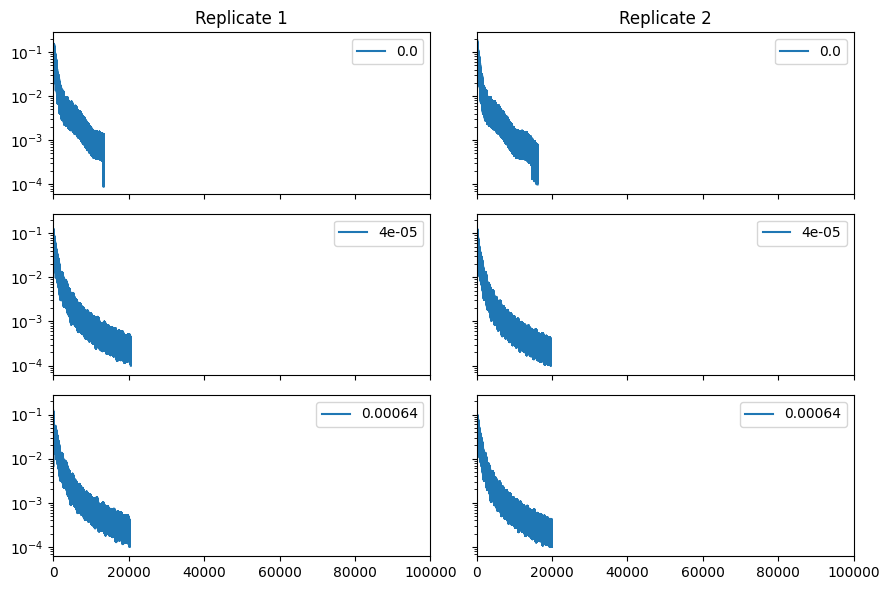

post_latent_fn=linear
smooth_obj_fn=cond_norm_equal_penalty


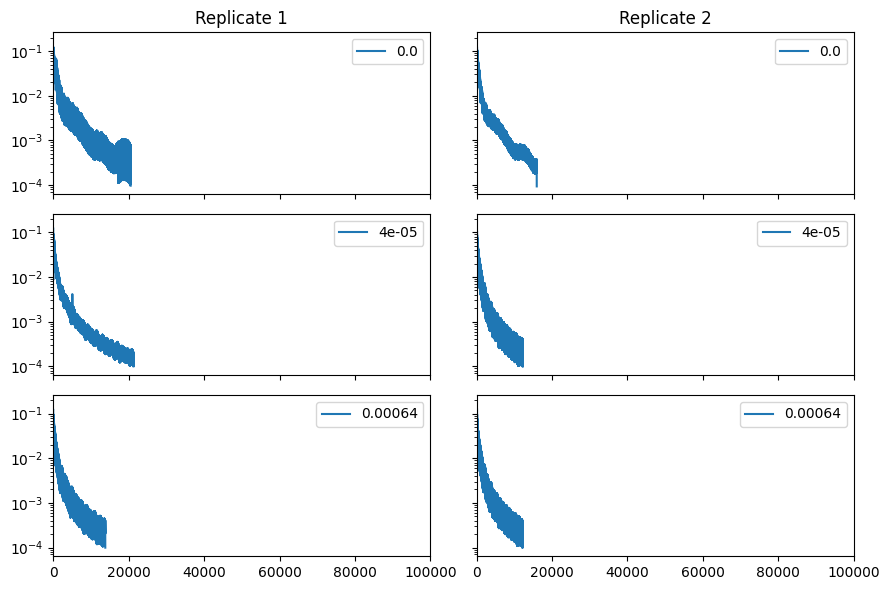

post_latent_fn=linear
smooth_obj_fn=cond_norm_penalty


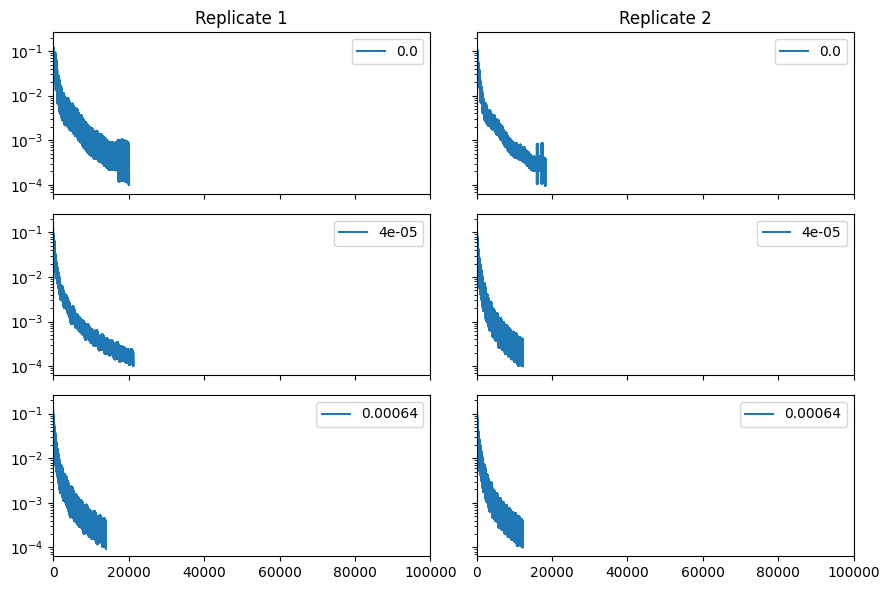

post_latent_fn=sigmoid
smooth_obj_fn=all_sample_norm


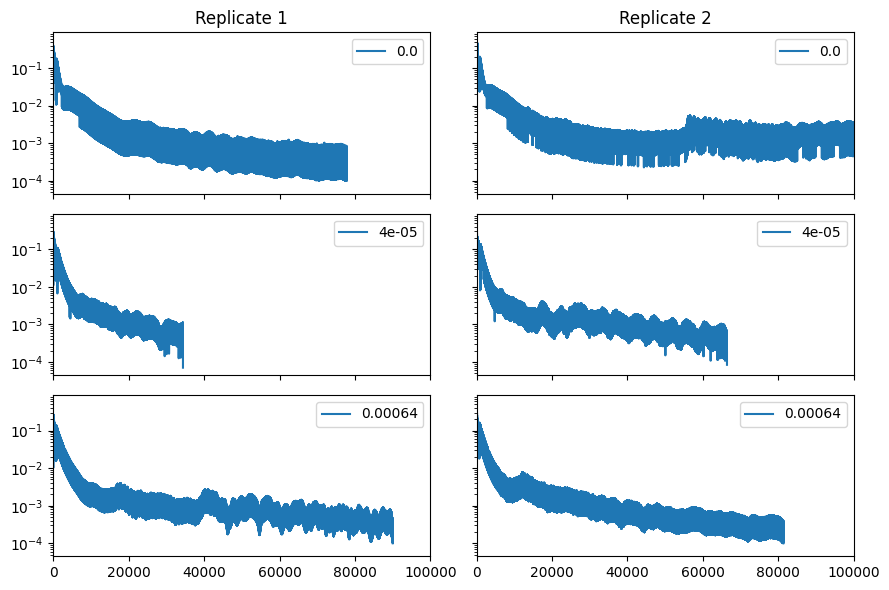

post_latent_fn=sigmoid
smooth_obj_fn=cond_norm_equal_penalty


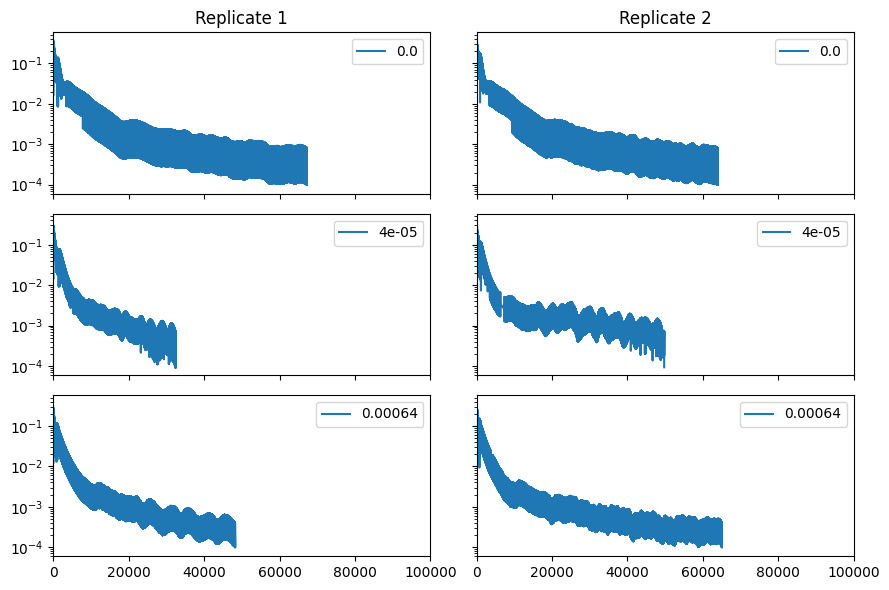

post_latent_fn=sigmoid
smooth_obj_fn=cond_norm_penalty


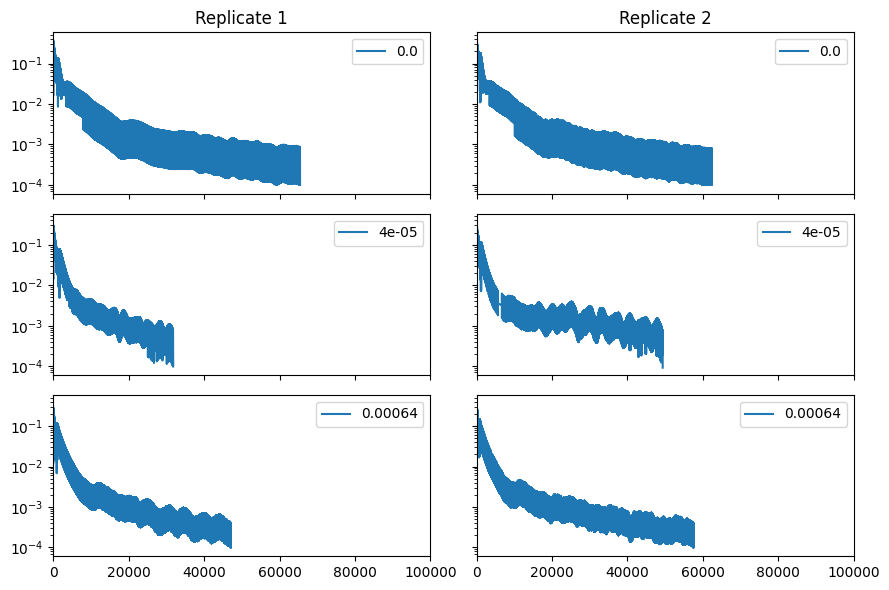

In [28]:
for group, df in results_df.groupby(list(non_lasso_groupers)):
    hyper_params = [f"{k}={v}" for k, v in zip(non_lasso_groupers, group)]
    print("\n".join(hyper_params))

    fig, ax = plt.subplots(
        len(df.lasso_coeff.unique()), 
        2, 
        # len(df.data_replicate.unique()), 
        figsize=(9, len(df.lasso_coeff.unique())*2),
        sharex=True,
        sharey=True
    )
    if not isinstance(ax, np.ndarray):
        ax = np.array([ax])
    if not isinstance(ax[0], np.ndarray):
        ax = np.array([ax])

    # plot the error for each model
    for i, lasso_coeff_cat in enumerate(sorted(df.lasso_coeff_cat.unique())):
        for j, data_replicate in enumerate(sorted(df.data_replicate.unique())):
            results_df_sub = df[(df.lasso_coeff_cat == lasso_coeff_cat) & (df.data_replicate == data_replicate)]
            for k, row in results_df_sub.iterrows():
                ax[i, j].plot(row.error, label=lasso_coeff_cat)

            ax[i, j].set_title(None)
            ax[i, j].set_yscale("log")
            # ax[i, j].set_title(f"lasso_coeff={lasso_coeff}, data_replicate={data_replicate}")
            ax[i, j].legend()
    ax[0, 0].set_title("Replicate 1")
    ax[0, 0].set_xlim(-5, 100005)
    ax[0, 1].set_title("Replicate 2")
    ax[0, 1].set_xlim(-5, 100005)
    fig.savefig(f"{output_dir}/error_trajectory.png")
    plt.tight_layout()
    plt.show()

In [29]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   data_replicate    36 non-null     object  
 1   lasso_coeff       36 non-null     float64 
 2   post_latent_fn    36 non-null     object  
 3   smooth_obj_fn     36 non-null     object  
 4   total_iterations  36 non-null     object  
 5   sparsity          36 non-null     object  
 6   params            36 non-null     object  
 7   D                 36 non-null     object  
 8   data              36 non-null     object  
 9   state             36 non-null     object  
 10  error             36 non-null     object  
 11  obj               36 non-null     object  
 12  converged         36 non-null     object  
 13  lasso_coeff_cat   36 non-null     category
dtypes: category(1), float64(1), object(12)
memory usage: 3.9+ KB


Extract mutation dataframes from `Data` object, and merge in the annotations from the row.

In [30]:
# define a function that takes a series (row) of the DataFrame, extracts, and merges annotations
def extract_mut_df_merge_annotations(row, times_seen_threshold=1, id_vars=["data_replicate", "equivariant", "lasso_coeff"]):
    mutations_df = row.data.mutations_df.copy()
    params = row.params
    for condition in params["β"]:
        assert len(params["β"][condition]) == mutations_df.shape[0]
        col_name = "β_" + condition
        mutations_df[col_name] = params["β"][condition]
    
    D = row.D
    D_str = []
    for i, r in enumerate(D):
        D_str.append(
            "+".join([f"{'-' if coef == -1 else ''}β_{list(params['β'].keys())[j]}" 
            for j, coef in enumerate(r) if coef != 0.0])
        )

    if "equivariant" not in row:
        D_str[1] = "reference_ghost_shift"
    else:
        if not row.equivariant == 'True':
            D_str[1] = "reference_ghost_shift"

    for name, shifts in zip(D_str, params["Δ"]):
        if name == "reference_ghost_shift":
            continue
        
        # TODO this does not account for bundle muts
        # print(name)
        # cond1, cond2 = name.split("+")
        # cond1_betas = mutations_df[
        #     (cond1[1:] if cond1.startswith("-") else cond1)
        # ].values * (-1 if cond1.startswith("-") else 1)
        # cond2_betas = mutations_df[
        #     (cond2[1:] if cond2.startswith("-") else cond2)
        # ].values * (-1 if cond2.startswith("-") else 1)
        # assert np.allclose(shifts, (cond1_betas + cond2_betas))
        # print(name, shifts)
        
        mutations_df[name] = shifts

    
    data = row.data
    if times_seen_threshold > 0:
        for condition in data.conditions:
            mutations_df = mutations_df[
                mutations_df[f"times_seen_{condition}"] >= times_seen_threshold
            ]
        
    for key in row.keys():
        if key in id_vars:
            mutations_df[key] = row[key]

    return mutations_df


So it's not the case that the $\Delta$ parameters are all equal to the difference in $\beta$'s. Let's investigate a sigle fit to see where they differ

In [31]:
set(string_features) - set(['lasso_coeff'])

{'data_replicate', 'post_latent_fn', 'smooth_obj_fn', 'total_iterations'}

In [32]:
mut_dfs = []
for i, row in results_df.iterrows():
    mut_dfs.append(
        extract_mut_df_merge_annotations(row, id_vars=set(string_features))
    )
mut_dfs = pd.concat(mut_dfs)
id_vars = list(set(string_features))
mut_dfs.sort_values(id_vars, inplace=True)
mut_dfs.head()

,mutation,wts,sites,muts,times_seen_Delta,times_seen_Omicron_BA1,times_seen_Omicron_BA2,β_Delta,β_Omicron_BA1,β_Omicron_BA2,β_Delta+-β_Omicron_BA1,-β_Omicron_BA1+β_Omicron_BA2,data_replicate,lasso_coeff,post_latent_fn,smooth_obj_fn,total_iterations
1,M1I,M,1,I,3.0,3.0,5.0,-1.515951,-2.586761,-1.741895,1.070809,0.844866,1,0.0,linear,all_sample_norm,100000
8,F2I,F,2,I,1.0,2.0,1.0,-0.584765,0.310681,0.565614,-0.895446,0.254933,1,0.0,linear,all_sample_norm,100000
9,F2L,F,2,L,7.0,12.0,18.0,0.318336,0.296576,0.005740,0.021759,-0.290836,1,0.0,linear,all_sample_norm,100000
10,F2S,F,2,S,4.0,7.0,11.0,0.464843,0.276345,0.532278,0.188498,0.255933,1,0.0,linear,all_sample_norm,100000
11,F2V,F,2,V,1.0,5.0,3.0,-0.506953,0.542423,0.846272,-1.049376,0.303848,1,0.0,linear,all_sample_norm,100000


In [33]:
id_vars

['post_latent_fn',
 'lasso_coeff',
 'total_iterations',
 'data_replicate',
 'smooth_obj_fn']

In [34]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

lasso_coeff=4e-05, smooth_obj_fn=all_sample_norm, post_latent_fn=sigmoid


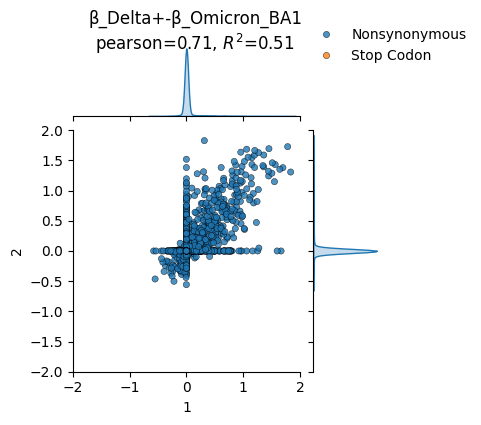

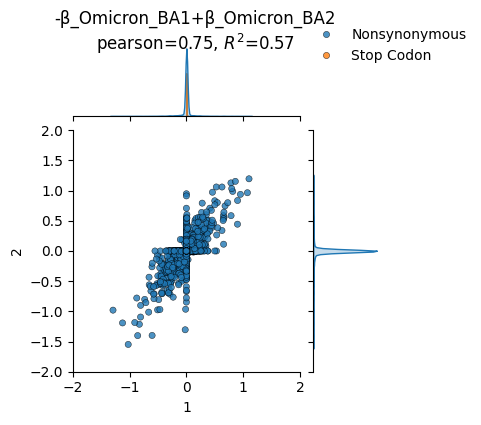

lasso_coeff=4e-05, smooth_obj_fn=cond_norm_equal_penalty, post_latent_fn=sigmoid


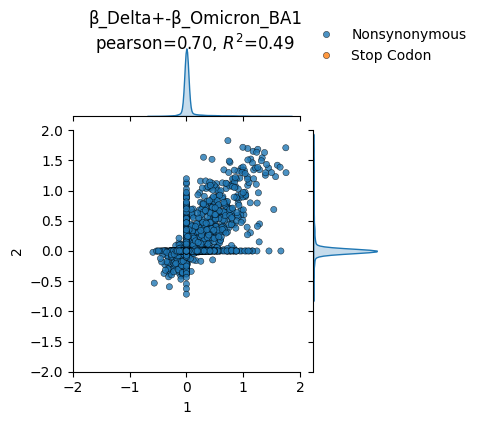

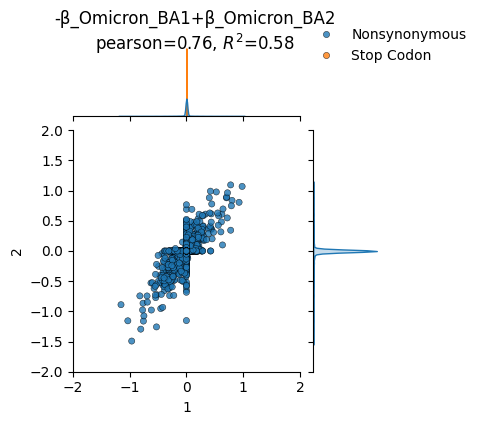

lasso_coeff=4e-05, smooth_obj_fn=cond_norm_penalty, post_latent_fn=sigmoid


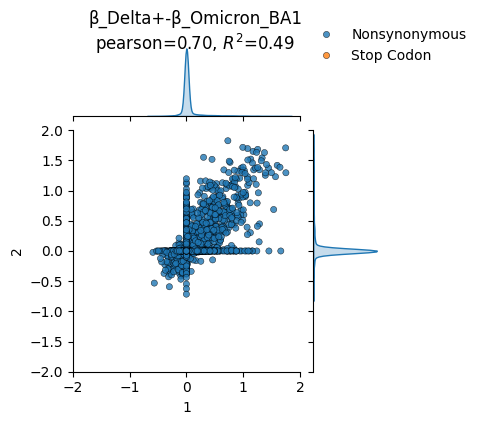

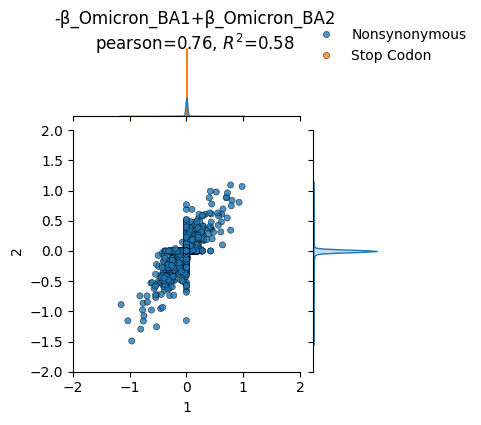

In [40]:
non_replicate_groupers = list(set(id_vars) - set(["data_replicate", "total_iterations"]))
for id, mut_df_lasso in mut_dfs.groupby(non_replicate_groupers):
    if not (id[0] == 4e-05 and id[2] == "sigmoid"):
        continue
    param_col_to_compare = [c for c in mut_df_lasso.columns if "β" in c]
    # fig, ax = plt.subplots(1, len(param_col_to_compare), figsize=(3 * len(param_col_to_compare), 3))
    title = ", ".join([f"{k}={v}" for k, v in zip(non_replicate_groupers, id)])
    print(title, flush=True)
    for fig_col, param_col in enumerate(param_col_to_compare):
        if "+" not in param_col:
            continue
        # pivot the table to have a column for each replicate 
        pivoted = mut_df_lasso.pivot(index="mutation", columns="data_replicate", values=param_col).dropna()
        pivoted["Mutation Type"] = ["Stop Codon" if "*" in mut else "Nonsynonymous" for mut in pivoted.index]
        # print(pivoted)
        r = pivoted[["1", "2"]].corr().iloc[0, 1]
        r2 = round(r**2, 2)
        alpha=0.5 if "+" in param_col else 0.1
        # sns.scatterplot(pivoted, x="1", y="2", alpha=alpha, ax=ax[fig_col])
        range = 2
        jp = sns.jointplot(
            pivoted, 
            x="1", 
            y="2", 
            xlim=[-range, range],
            ylim=[-range, range],
            height=4, 
            ratio=3,
            hue="Mutation Type",
            kind="scatter",
            alpha=0.8,
            s=20,
            edgecolor="black",
            # density_joint=True,
        )
        # move legend outside 
        jp.ax_joint.legend(loc='center left', bbox_to_anchor=(1, 1.35), frameon=False)
        title = f"{param_col}\npearson={r:.2f}, $R^2$={r2}"
        # move title up

        jp.figure.suptitle(title, y=1.05)
        plt.show()
        # break

    # plt.suptitle(title)
    # plt.tight_layout()
    # break


Let's plot the sparsity and replicate correlations as a function of the lasso weight

In [41]:

fixed_ref_column_shifts={
    "β_Delta+-β_Omicron_BA1" : "shift_Delta",
    "-β_Omicron_BA1+β_Omicron_BA2" : "shift_Omicron_BA2",
}

# equivariant_column_shifts = {
    # "β_Delta+-β_Omicron_BA1" : "Δ()",
    # "-β_Omicron_BA1+β_Omicron_BA2" : "Omicron_BA2",
# }

In [42]:
chosen_lasso_strength = 0.00004

In [43]:
# if not os.path.exists(output_dir): os.mkdir(output_dir)

rc_kwargs = {
    'legend.frameon': False,
    "font.size" : 11,
    "font.weight" : "normal"
}

plt.rcParams.update(**rc_kwargs)

In [44]:
non_lasso_replicate_groupers = set(non_replicate_groupers) - set(["lasso_coeff"])

smooth_obj_fn=all_sample_norm, post_latent_fn=linear


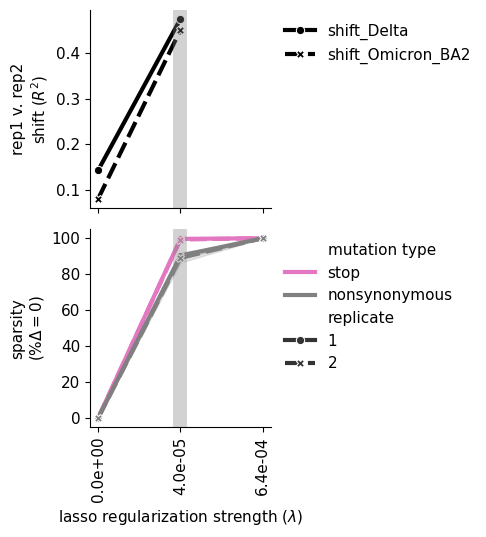

smooth_obj_fn=all_sample_norm, post_latent_fn=sigmoid


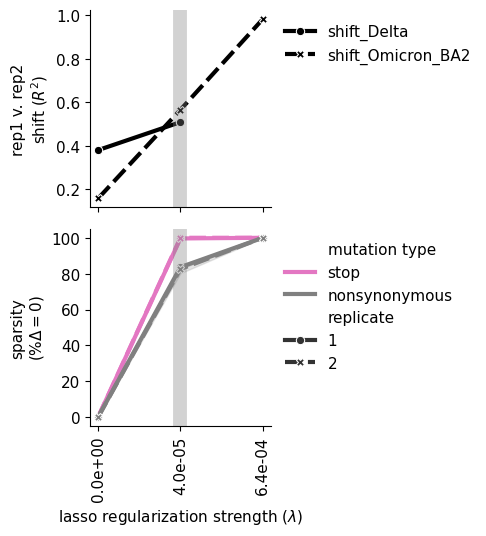

smooth_obj_fn=cond_norm_equal_penalty, post_latent_fn=linear


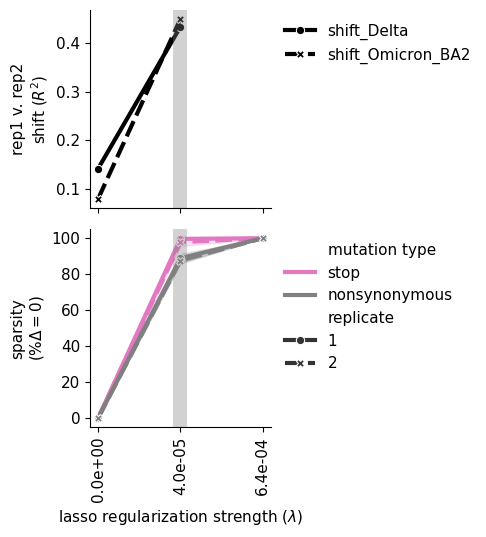

smooth_obj_fn=cond_norm_equal_penalty, post_latent_fn=sigmoid


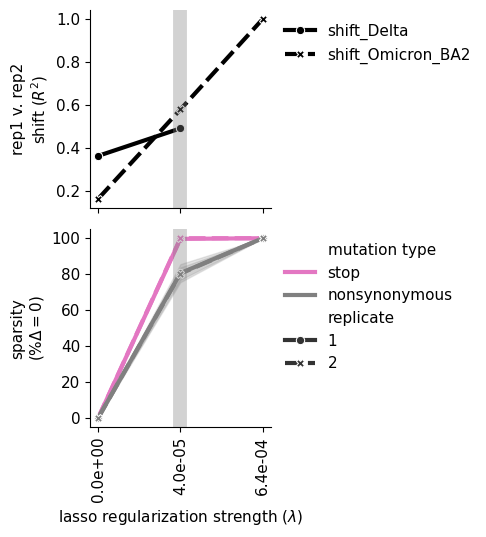

smooth_obj_fn=cond_norm_penalty, post_latent_fn=linear


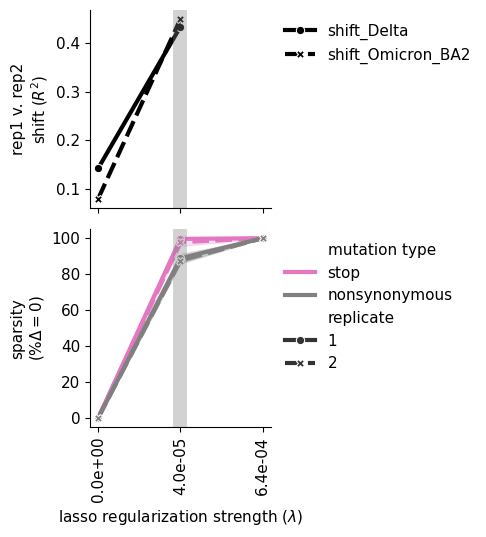

smooth_obj_fn=cond_norm_penalty, post_latent_fn=sigmoid


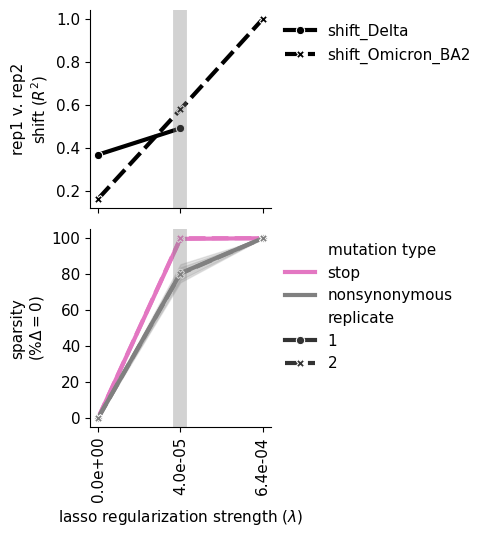

In [45]:
# mut_df = mut_dfs
for id, mut_df in mut_dfs.groupby(list(non_lasso_replicate_groupers)):

    title = ", ".join([f"{k}={v}" for k, v in zip(non_lasso_replicate_groupers, id)])
    print(title, flush=True)
    corr_sparsity_dict = defaultdict(list)
    for lasso_coeff, mut_df_lasso in mut_df.groupby("lasso_coeff"):
        corr_sparsity_dict["scale_coeff_lasso_shift"].append(lasso_coeff)
        param_col_to_compare = [c for c in mut_df_lasso.columns if "β" in c]
        for fig_col, param_col in enumerate(param_col_to_compare):
            if "+" not in param_col: continue
            pivoted = mut_df_lasso.pivot(index="mutation", columns="data_replicate", values=param_col).dropna()
            # print(pivoted.index.str.split())
            muts = pivoted.index.values
            pivoted = pivoted.assign(is_stop = ["*" in m for m in muts])
            # pivoted = pivoted.assign(is_stop = pivoted.index.str.contains("*"))

            r = pivoted.corr().iloc[0, 1]

            corr_sparsity_dict[f"replicate_corr_{param_col}"].append(r)
            for replicate in ["1", "2"]:

                corr_sparsity_dict[f"{replicate}_stop_sparsity_{param_col}"].append((pivoted.query("is_stop")[replicate]==0).mean())
                corr_sparsity_dict[f"{replicate}_nonsyn_sparsity_{param_col}"].append((pivoted.query("~is_stop")[replicate]==0).mean())

    corr_sparsity_df = pd.DataFrame(corr_sparsity_dict)
    corr_df = (
        corr_sparsity_df[["scale_coeff_lasso_shift"]+[c for c in corr_sparsity_df.columns if "replicate_corr" in c]]
        .melt(id_vars="scale_coeff_lasso_shift", var_name="shift_params", value_name="correlation")
        .assign(
            mut_param = lambda x: x["shift_params"].str.split("_").str[2:].str.join("_")
        )
        .drop(columns="shift_params")
    )
    # corr_df
    sparsity_df = (
        corr_sparsity_df[["scale_coeff_lasso_shift"]+[c for c in corr_sparsity_df.columns if "sparsity" in c]]
        .melt(id_vars="scale_coeff_lasso_shift", var_name="shift_params", value_name="sparsity")
        .assign(
            replicate = lambda x: x["shift_params"].str.split("_").str[0],
            mut_type = lambda x: x["shift_params"].str.split("_").str[1],
            mut_param = lambda x: x["shift_params"].str.split("_").str[3:].str.join("_")
        )
        .drop(columns="shift_params")
    )
    # sparsity_df
    # saveas="shrinkage_analysis_trace_plots_beta"

    fig, ax = plt.subplots(2, figsize=[5, 5.5], sharex=True)

    # replicate correlation
    iter_ax = ax[0]
    sns.lineplot(
        data=(
            corr_df
            .rename({"mut_param":"shift params"}, axis=1)
            .replace(fixed_ref_column_shifts)
            .assign(
                scale_coeff_lasso_shift = [
                    f"{l:.1e}" 
                    for l in corr_df.scale_coeff_lasso_shift
                ],
                correlation = lambda x: x.correlation**2
            )
            .reset_index(drop=True)
        ),
        x="scale_coeff_lasso_shift",
        y="correlation",
        style="shift params",
        markers=True,
        ax=iter_ax,
        linewidth=3,
        color="black"
    )
    iter_ax.set_ylabel("rep1 v. rep2\nshift $(R^2)$")
    # move legend outside of plot
    iter_ax.legend(
        bbox_to_anchor = (1, 1), 
        loc='upper left', 
        frameon=False
    )



    # # plot loss
    # iter_ax = ax[1]
    # sns.lineplot(
    #     data = (
    #         cross_validation_df.query("condition=='total'")
    #         .assign(
    #             # lasso_strength = [f"{l:.1e}" for l in sparsity_df.scale_coeff_lasso_shift]
    #             # lasso_strength = lambda x: f"{x.scale_coeff_lasso_shift:.1e}"
    #             lasso_strength = lambda x: x['scale_coeff_lasso_shift'].apply(lambda y: f'{y:.1e}')
    #         )
    #     ),
    #     x="lasso_strength",
    #     y="loss",
    #     ax=iter_ax,
    #     hue="split",
    #     style="dataset_name",
    #     palette={"training":"slategrey", "validation":"#2CA02C"},
    #     markers=True,
    #     linewidth=3
    # )
    # # move legend outside of plot
    # iter_ax.legend(
    #     bbox_to_anchor = (1, 1), 
    #     loc='upper left', 
    #     frameon=False
    # )


    # plot sparsity
    iter_ax = ax[1]
    sns.lineplot(
        data=(
            sparsity_df
            # .rename({"dataset_name":"replicate"}, axis=1)
            .rename({"mut_param":"shift params", "mut_type":"mutation type"}, axis=1)
            # .replace({"Data-0":"rep-1", "Data-1":"rep-2"})
            .replace({"nonsyn":"nonsynonymous", "stop":"stop"})
            .replace(fixed_ref_column_shifts)
            .assign(
                scale_coeff_lasso_shift = [f"{l:.1e}" for l in sparsity_df.scale_coeff_lasso_shift],
                sparsity_percent = lambda x: x.sparsity * 100,
            )
        ),
        x="scale_coeff_lasso_shift",
        y="sparsity_percent",
        hue="mutation type",
        style="replicate",
        palette={"nonsynonymous":"grey", "stop":"#E377C2"},
        markers=True,
        legend=True,
        ax=iter_ax,
        linewidth=3
    )
    # move legend outside of plot
    iter_ax.legend(
        bbox_to_anchor = (1, 1), 
        loc='upper left', 
        frameon=False
    )
    # rotate x labels
    iter_ax.set_xticklabels(
        iter_ax.get_xticklabels(), 
        rotation=90, 
        ha='center'
    )
    iter_ax.set_ylabel("sparsity\n$(\%\Delta=0)$")
    iter_ax.set_xlabel(f"lasso regularization strength ($\lambda$)")

    for axes in ax:
        axes.axvline(
            f"{chosen_lasso_strength:.1e}", 
            color="grey",
            linewidth=10,
            alpha=0.35
        )

    sns.despine(fig)
    plt.tight_layout()
    # plt.tight_layout()
    # fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
    # fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')
    # plt.show()

    plt.show()

Next, let's plot the shift results

In [30]:

rep_1_site_map = results_df.query("data_replicate == '1'").iloc[0].data.site_map.copy()
rep_1_site_map.index.name="site"
rep_1_site_map.reset_index(inplace=True)
rep_1_site_map


,site,Delta,Omicron_BA1,Omicron_BA2
0,1,M,M,M
1,2,F,F,F
2,3,V,V,V
3,4,F,F,F
4,5,L,L,L
...,...,...,...,...
1234,1248,C,C,C
1235,1249,S,S,S
1236,1250,C,C,C
1237,1251,G,G,G


In [31]:

rep_2_site_map = results_df.query("data_replicate == '2'").iloc[0].data.site_map.copy()
rep_2_site_map.index.name="site"
rep_2_site_map.reset_index(inplace=True)
rep_2_site_map

,site,Delta,Omicron_BA1,Omicron_BA2
0,1,M,M,M
1,2,F,F,F
2,3,V,V,V
3,4,F,F,F
4,5,L,L,L
...,...,...,...,...
1234,1248,C,C,C
1235,1249,S,S,S
1236,1250,C,C,C
1237,1251,G,G,G


In [32]:
unshared_sites = set(rep_1_site_map["site"]).symmetric_difference(set(rep_2_site_map["site"]))
shared_sites = set(rep_1_site_map["site"]).union(set(rep_2_site_map["site"]))
unshared_sites

{422, 898}

In [33]:
site_map = pd.concat([rep_1_site_map, rep_2_site_map], axis=0).drop_duplicates().set_index("site", verify_integrity=True).sort_index()
site_map.index.name=None
site_map.drop(unshared_sites, inplace=True)
site_map

,Delta,Omicron_BA1,Omicron_BA2
1,M,M,M
2,F,F,F
3,V,V,V
4,F,F,F
5,L,L,L
...,...,...,...
1248,C,C,C
1249,S,S,S
1250,C,C,C
1251,G,G,G


In [34]:
rep_1_mutations = results_df.query("data_replicate == '1'").iloc[0].data.mutations
rep_2_mutations = results_df.query("data_replicate == '2'").iloc[0].data.mutations
shared_mutations = set(rep_1_mutations).intersection(set(rep_2_mutations))
len(shared_mutations)

9983

In [35]:

mut_df_replicates = (
    mut_dfs
    .query("lasso_coeff == 4e-05 and mutation in @shared_mutations")
    .drop(columns=[c for c in mut_dfs.columns if c not in ["wts", "sites", "muts"] and "+" not in c])
    .rename(
        columns={
            "β_Delta+-β_Omicron_BA1" : "avg_shift_Delta",
            "-β_Omicron_BA1+β_Omicron_BA2" : "avg_shift_Omicron_BA2",
        }
    )
    .groupby(["wts", "sites", "muts"])
    .mean()
    .reset_index()
)
mut_df_replicates

,wts,sites,muts,avg_shift_Delta,avg_shift_Omicron_BA2
0,A,27,D,0.000000,0.156343
1,A,27,E,0.000000,0.000000
2,A,27,G,0.000000,0.000000
3,A,27,L,0.000000,0.000000
4,A,27,P,0.104674,-0.621359
...,...,...,...,...,...
6740,Y,1209,N,0.000000,0.000000
6741,Y,1215,*,0.000000,0.000000
6742,Y,1215,C,0.000000,0.000000
6743,Y,1215,F,0.050734,0.000000


In [36]:
# some renaming and wrangling
mut_df_replicates["sense"] = ["stop" if mut == "*" else "nonsynonymous" for mut in mut_df_replicates.muts]
rename_omicron = {
    c:"_".join(c.split("_")[:2]+[c.split("_")[3]])
    for c in mut_df_replicates.columns if "Omicron" in c
}
mut_df_replicates.rename(rename_omicron, axis=1, inplace=True)
print(mut_df_replicates)


     wts  sites muts  avg_shift_Delta  avg_shift_BA2          sense
0      A     27    D         0.000000       0.156343  nonsynonymous
1      A     27    E         0.000000       0.000000  nonsynonymous
2      A     27    G         0.000000       0.000000  nonsynonymous
3      A     27    L         0.000000       0.000000  nonsynonymous
4      A     27    P         0.104674      -0.621359  nonsynonymous
...   ..    ...  ...              ...            ...            ...
6740   Y   1209    N         0.000000       0.000000  nonsynonymous
6741   Y   1215    *         0.000000       0.000000           stop
6742   Y   1215    C         0.000000       0.000000  nonsynonymous
6743   Y   1215    F         0.050734       0.000000  nonsynonymous
6744   Y   1215    H         0.265866       0.081378  nonsynonymous

[6745 rows x 6 columns]


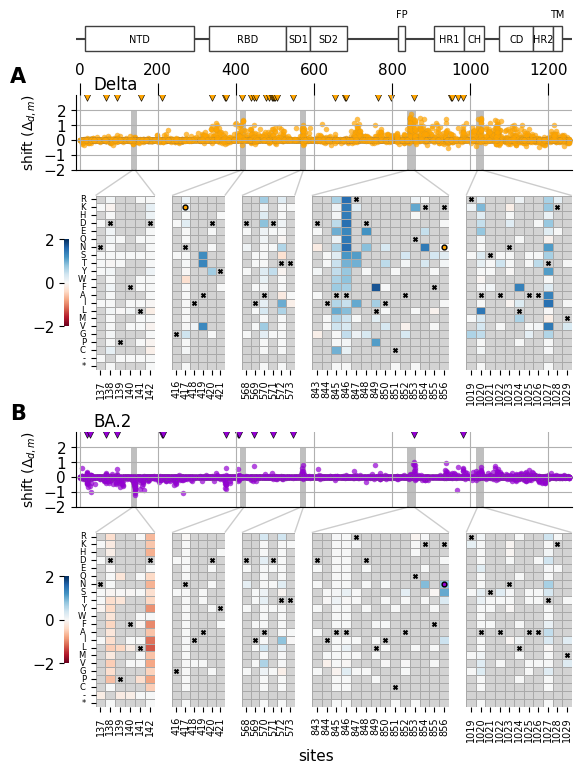

In [37]:

site_map = site_map.reset_index().rename(
    {"index":"sites", "Omicron_BA2": "BA2", "Omicron_BA1":"BA1"}, axis=1
).set_index("sites")

saveas = "shift_by_site_heatmap_zoom"

site_ranges = {
    "zoom1" : [137, 142],
    "zoom2" : [416, 421],
    "zoom3" : [568, 573],
    "zoom4" : [843, 856],
    "zoom5" : [1019, 1029]
}

# heatmap ax width ratios
width_ratios = [(end-start) for key, (start, end) in site_ranges.items()]

# make the first one a little bigger for the color bar
width_ratios[0] += width_ratios[0] * 0.5


# Plot domain architecture in primary sequence
# based on structure papers (Gobeil et al., 2022, Molecular Cell)
# (Duan et al., 2020, Frotiers in Immunology)
domain_dict = {
    'NTD' : [13, 293],
    'RBD' : [330, 528],
    'SD1' : [528, 590],
    'SD2' : [590, 685],
    'FP' : [815, 834],
    'HR1' : [907, 985],
    'CH' : [985, 1035],
    'CD' : [1075, 1162],
    'HR2' : [1162, 1211],
    'TM' : [1211, 1234],
}

sort_order = [
    "R","K","H","D","E","Q","N","S",
    "T","Y","W","F","A","I","L","M",
    "V","G","P","C","-","*",
]

fig = plt.figure( figsize=[6.4, 9])
axs = fig.subplot_mosaic(
    [
        ["Annotation"]*5,
        ["Delta"]*5,
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        ["."]*5,
        ["BA2"]*5,
        [f"{k}_BA2" for k in list(site_ranges.keys())],
        [f"{k}_BA2" for k in list(site_ranges.keys())]
    ],
    
    height_ratios=[
        1.5, 
        2, 
        2, 
        2,
        0.3,
        2,
        2, 
        2
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
    width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)

# derived from
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axes_zoom_effect.html
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect03(ax1, ax2, xmin, xmax, **kwargs):

    mybbox1 = ax1.bbox
    
    bbox = Bbox.from_extents(xmin, 0, xmax, 1)
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=2, loc2a=3, loc1b=1, loc2b=4,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

#############
# sitewise
#############


pal = sns.color_palette('colorblind')
cs = ['darkviolet', 'orange']
cs = {
    'BA2' : 'darkviolet', 
    'Delta' : 'orange'
}

# Plot per-site metric
metric_prefix = 'max_abs_shift_'
for (i, homolog) in enumerate(['BA2', 'Delta']):

    sns.scatterplot(
        x='sites', 
        y=f'avg_shift_{homolog}',
        data=mut_df_replicates, 
        s=15,
        alpha=0.7,
        edgecolor="grey",
        linewidth=0.05,
        ax=axs[homolog], 
        color=cs[homolog],
        label=""
    )
    
    nis = site_map.query(f"{homolog} != BA1")
    sns.scatterplot(
        x='sites', 
        y=np.repeat(2.9, len(nis)),
        data=nis, 
        s=30,
        ax=axs[homolog],
        marker='v',
        facecolor=cs[homolog], 
        edgecolor="k"
    )

    axs[homolog].grid()
    axs[homolog].set(
        xlim=[-10,1260],
        ylim=[-2, 3],
        yticks=[-2, -1, 0, 1, 2],
    )
    sns.despine(ax=axs[homolog])
    
    axs[homolog].tick_params(
        axis='x', 
        bottom=False,
        labelbottom=False,
        labeltop=True if homolog == "Delta" else False,
        top=True if homolog == "Delta" else False,
        size=9
    )
    axs[homolog].set_xlabel(None)
    axs[homolog].set_ylabel('shift ($\Delta_{d,m}$)', size=10)


axs["BA2"]._shared_axes['x'].join(axs["BA2"], axs["Delta"])

plot_rectangles = True
for zoom, site_range in site_ranges.items():
    if not plot_rectangles:
        continue
    (site_i, site_j) = site_range
    for (i, homolog) in enumerate(['BA2', 'Delta']):
        rect = patches.Rectangle(
            (site_i-5, -2), site_j-site_i+11, 4,
            edgecolor='none', facecolor='0.75', zorder=0
        )
        axs[homolog].add_patch(rect)
        
        
#############
# Annotation
#############

for (domain, (start, end)) in domain_dict.items():
    rectangle = patches.Rectangle((start, 1), end-start, 2, edgecolor='0.25', facecolor='white')
    axs["Annotation"].add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry - 0.05 + rectangle.get_height()/2.0
    if domain in ['FP', 'TM']:
        cy += 2
    axs["Annotation"].annotate(
        domain, (cx, cy), color='black', ha='center', va='center',
        fontsize=7
    )

axs["Annotation"].set(ylim=[-0.5,4], yticks=[])
sns.despine(left=True, bottom=True, ax=axs["Annotation"])

axs["Annotation"].sharex(axs["BA2"])
axs["Annotation"].axhline(2, c='0.25', zorder=0)
axs["Annotation"].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

#############
# Heatmap
#############

for (i, homolog) in enumerate(['Delta', 'BA2']):
    
    df_shifts_wide = mut_df_replicates.pivot(
        index='muts', 
        columns='sites', 
        values=f'avg_shift_{homolog}'
    ).loc[sort_order, :]

    for zoom, (start, end) in site_ranges.items():
        
        iter_ax = axs[f"{zoom}_{homolog}"]
        iter_ax.set_facecolor("lightgrey")
        sites = [s for s in list(range(start, end+1)) if s in df_shifts_wide.columns]
        
        sns.heatmap(
            df_shifts_wide.loc[:, sites], 
            cbar=True if zoom == "zoom1" else False,
            cbar_kws={
                "shrink": 0.5, 
                "location":'left',
                'anchor': (-1.5, 0.5),
                'label' : None
            },
            ax = iter_ax,
            linewidth=.5, 
            linecolor="darkgrey",
            center=0,
            cmap='RdBu',
            vmin=-2.0,
            vmax=2.0,
            xticklabels=False,
            yticklabels=False,
        )

        for i, site in enumerate(sites):
            for j, mut in enumerate(sort_order):
                
                is_ref_wt = True if mut == site_map.loc[site,"BA1"] else False
                if is_ref_wt:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="x", 
                        s=8, 
                        c="black"
                    )
                is_nis = (
                    True 
                    if mut ==  site_map.loc[site,homolog] and
                    mut !=  site_map.loc[site,"BA1"]
                    else False
                )
                
                if is_nis:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="o", 
                        s=12, 
                        facecolors=cs[homolog],
                        edgecolors="black"
                    )

        if zoom != "zoom1":
            axs[f"{zoom}_{homolog}"].tick_params(axis='y', left=False, labelleft=False)
            sns.despine(left=True, bottom=True, ax=axs[f"{zoom}_{homolog}"])  
        else:
            axs[f"{zoom}_{homolog}"].set_yticks(
                [s+0.5 for s in range(len(sort_order))],
                labels=sort_order, 
                va="center",
                size=6
            )
            
        axs[f"{zoom}_{homolog}"].set_ylabel(None)
            
        if homolog != "Delta":
            axs[f"{zoom}_{homolog}"].sharex(axs[f"{zoom}_Delta"])
        axs[f"{zoom}_{homolog}"].set_xticks(
            [s+0.5 for s in range(len(sites))],
             labels=sites, 
             ha="center",
            rotation=90,
            size=7
        )
        axs[f"{zoom}_{homolog}"].set_xlabel(None)

for zoom, (start, end) in site_ranges.items():
    for homolog in ['Delta', 'BA2']:
        zoom_effect03(axs[f"{zoom}_{homolog}"], axs[homolog], start, end, alpha= 0.2)

fig.text(
    0.5, 0.05, 'sites',
    ha='center'
)

axs["Delta"].text(
    -0.1, 1.25, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["Delta"].transAxes
)
axs["Delta"].text(
    0.035, 1.15, 
    f"Delta", 
    ha="left", va="center", 
    size=12,
    transform=axs["Delta"].transAxes
)

axs["BA2"].text(
    -0.1, 1.25, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["BA2"].transAxes
)
axs["BA2"].text(
    0.035, 1.15, 
    f"BA.2", 
    ha="left", va="center", 
    size=12,
    transform=axs["BA2"].transAxes
)

# fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
# fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')
plt.show()